<font size=6><center>**Helpful guidelines for hosting in Boston with Airbnb** </center></font>

In [563]:
# Imports
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ast import literal_eval
import keplergl as kgl
import geoplot

# Machine Learning
from sklearn.linear_model import Lasso, Ridge, LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Magic Functions
%matplotlib inline

# Functions

In [462]:
def make_ax(w, h):
    """
    INPUT:
    w - Width of a figure desired
    h - Height of the figure desired
    
    OUTPUT:
    fig - Figure with the desired dimensions
    ax - axis for the figure desired
    """
    
    fig = plt.figure(figsize = (w,h))
    ax = fig.gca()
    return fig, ax

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    INPUT:
    ax -  The matplotlib object containing the axes of the plot to annotate.
    spacing (int) - The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

def add_geometry(df):
    df = df.reset_index() # reset index so merge is possible
    neighbourhoods_geo = gpd.read_file('Boston_Neighborhoods.geojson')[["Name", "geometry"]] # read neighbourhood shp
    df = df.merge(neighbourhoods_geo, left_on='neighbourhood_cleansed', right_on='Name', how='left')
    df = gpd.GeoDataFrame(df, geometry='geometry')
    df.crs = {'init': 'EPSG:2249'}
    df.to_crs(4326, inplace=True) # change projection to lat long
    df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
    df['coords'] = [coords[0] for coords in df['coords']] # create new coord feature for the annotation
    return df

def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['feature'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    return coefs_df

# Reading AirBnB Data

In [463]:
# Reading the previously processed datasets
listings = pd.read_csv('airbnb_processed_data.csv', parse_dates=["host_since", "last_scraped"])
calendar = pd.read_csv('calendar_processed.csv', parse_dates=['date'])

Get some nice and simple statistics on both datasets

In [464]:
listings.describe()

,id,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_verifications_amex,host_verifications_email,host_verifications_facebook,host_verifications_google,host_verifications_jumio,host_verifications_kba,host_verifications_linkedin,host_verifications_manual_offline,host_verifications_manual_online,host_verifications_phone,host_verifications_reviews,host_verifications_sent_id,host_verifications_weibo,amenities_24-Hour Check-in,amenities_Air Conditioning,amenities_Breakfast,amenities_Buzzer/Wireless Intercom,amenities_Cable TV,amenities_Carbon Monoxide Detector,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Elevator in Building,amenities_Essentials,amenities_Family/Kid Friendly,amenities_Fire Extinguisher,amenities_First Aid Kit,amenities_Free Parking on Premises,amenities_Free Parking on Street,amenities_Gym,amenities_Hair Dryer,amenities_Hangers,amenities_Heating,amenities_Hot Tub,amenities_Indoor Fireplace,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Laptop Friendly Workspace,amenities_Lock on Bedroom Door,amenities_Other pet(s),amenities_Paid Parking Off Premises,amenities_Pets Allowed,amenities_Pets live on this property,amenities_Pool,amenities_Safety Card,amenities_Shampoo,amenities_Smoke Detector,amenities_Smoking Allowed,amenities_Suitable for Events,amenities_TV,amenities_Washer,amenities_Washer / Dryer,amenities_Wheelchair Accessible,amenities_Wireless Internet,host_for_days
count,3.495000e+03,3.495000e+03,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3.495000e+03,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000,3495.000000
mean,8.462630e+06,2.499079e+07,0.827871,0.733479,0.111016,59.800572,0.997711,0.729041,42.339885,-71.085040,2.979399,1.203004,1.223748,1.569385,159.503577,45.904435,1.413734,10.876109,3.131617,2.944345e+04,8.619170,21.764235,38.488984,179.008584,19.271531,-2163.064378,-2255.710157,-2241.530186,-2246.953648,-2241.226609,-2252.862661,-2250.185694,0.166237,0.018598,0.065522,1.575740,0.022890,0.974535,0.177110,0.030043,0.406295,0.355365,0.023748,0.043491,0.020601,0.997139,0.929614,0.000858,0.002861,0.347067,0.782833,0.088984,0.232332,0.490129,0.680114,0.051216,0.063233,0.072961,0.685837,0.240916,0.836910,0.521030,0.438340,0.295565,0.232618,0.002575,0.131617,0.505579,0.556223,0.943920,0.046638,0.105866,0.717883,0.511016,0.915308,0.511588,0.133047,0.004578,0.001144,0.134764,0.120172,0.043491,0.127039,0.675536,0.810587,0.026896,0.037768,0.724464,0.686695,0.

In [465]:
calendar.describe()

,listing_id,available,price
count,1.308890e+06,1.308890e+06,643037.000000
mean,8.442118e+06,4.912842e-01,198.438909
std,4.500149e+06,4.999242e-01,180.142913
min,3.353000e+03,0.000000e+00,11.000000
25%,4.679319e+06,0.000000e+00,85.000000
50%,8.578710e+06,0.000000e+00,150.000000
75%,1.279603e+07,1.000000e+00,255.000000
max,1.493346e+07,1.000000e+00,7163.000000


In [466]:
neighbourhoods_geo = gpd.read_file('Boston_Neighborhoods.geojson')[["Name", "geometry"]]
listings = listings.merge(neighbourhoods_geo, left_on='neighbourhood_cleansed', right_on='Name')
listings = gpd.GeoDataFrame(listings, geometry='geometry')
listings.crs = {'init': 'EPSG:2249'}
listings.to_crs(4326, inplace=True)

/usr/local/lib/python3.5/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


# Business Understading - Hosting in Boston

## Which neighbourhoods are the better for hosting?

In order to answer this question, let us first take a look at the different pricings, reviews per month and location rating scores fot the different neighbourhoods.

**Why are these important:** 
- *Price*: We need to understand which neighbourhoods people can host for a higher price for higher profit.
- *Reviews per Month*: Higher price is not everything. We need a high amount of people coming in.
- *Location Rating*: It is useful to know which neighbourhoods the customers rate best to understand neighbourhood stay attractiveness.

### Neighbourhoods with higher price per day

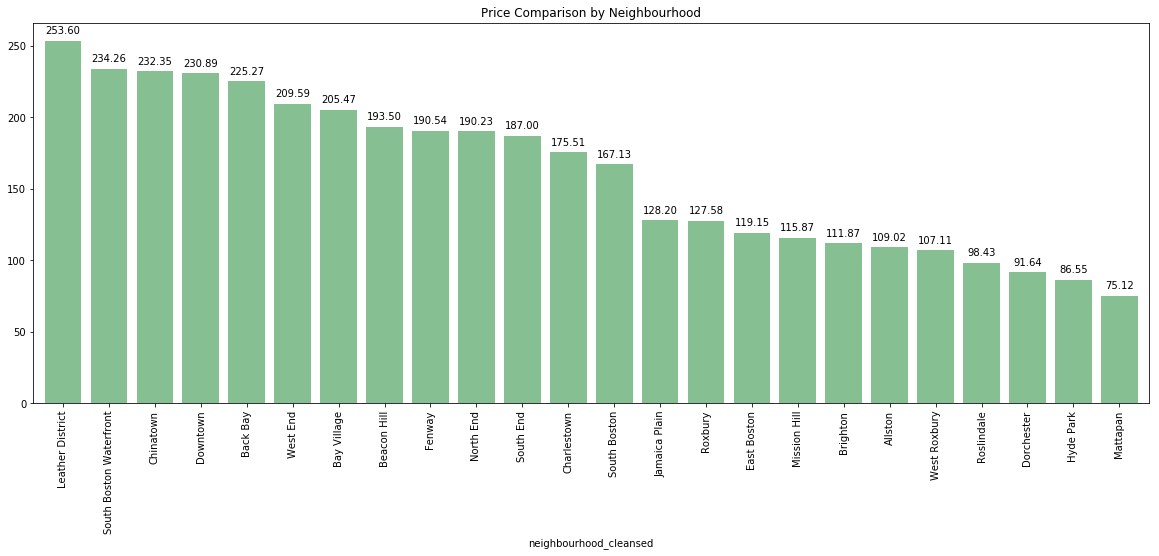

In [467]:
fig, ax = make_ax(20, 7)

# Get mean price per night of listings within each neighbourhood
neighbourhoods_prices = listings.groupby('neighbourhood_cleansed').price.mean().sort_values(ascending=False)
neighbourhoods_prices.plot(kind='bar', color='#86bf91', zorder=2, width=0.8, ax=ax)
ax.set_title('Price Comparison by Neighbourhood');
add_value_labels(ax)

/usr/local/lib/python3.5/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


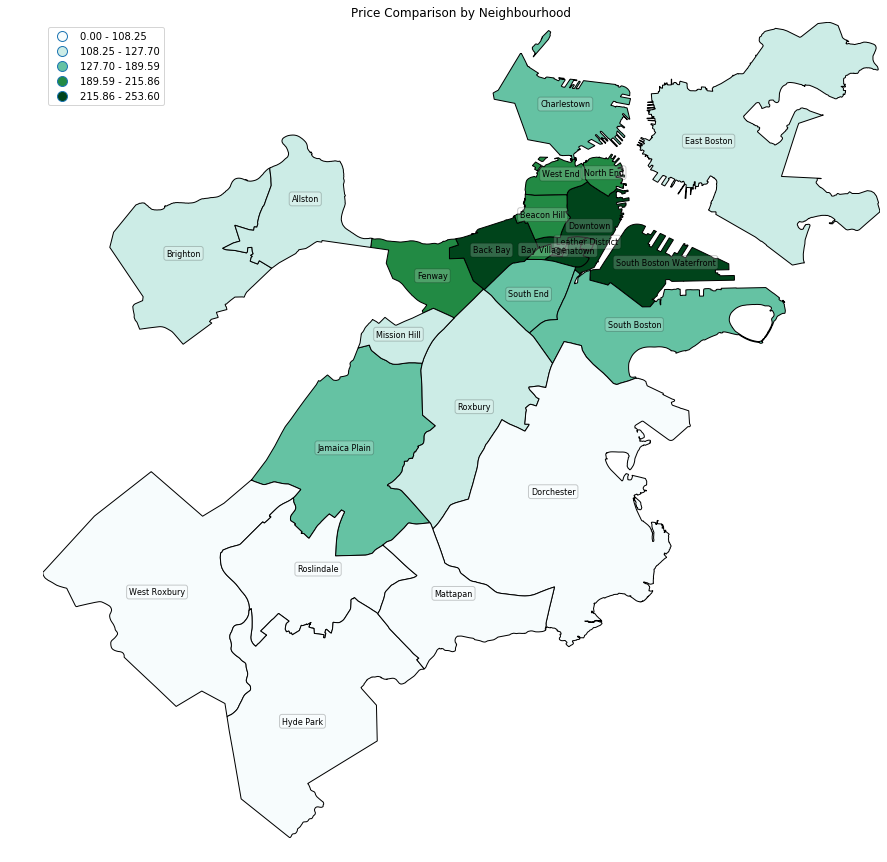

In [468]:
fig, ax = make_ax(15, 15)

# add geometry column 
neighbourhood_prices_geo = add_geometry(neighbourhoods_prices)
geoplot.choropleth(neighbourhood_prices_geo, hue='price', cmap = 'BuGn', legend=True, ax=ax);
ax.set_title('Price Comparison by Neighbourhood');

# Input the Neighbourhood labels on the polygons
for idx, row in neighbourhood_prices_geo.iterrows():
    ax.annotate(s=row['neighbourhood_cleansed'], 
                xy=row['coords'],
                bbox=dict(boxstyle="round", alpha=0.2, fc='White'), 
                horizontalalignment='center', fontsize=8)


- With the previous visualizations it is possible to see the mean rent price for listings in the different neighbourhoods.
- The Most Expensive Neighbourhoods are **Leather Distric** (253.6 USD) , **South Boston Waterfront** (234.3 USD) and **Chinatown** (232.4 USD)
- The Cheapest Neighbourhoods are **Dorchester** (91.6 USD), **Hyde Park** (86.5 USD) and **Mattapan** (75.1 USD)
- Plus, as it was expected, neighbourhoods closer to the center are more expensive
- So far the closest to the center the better.

### More Attractive Neighbourhoods

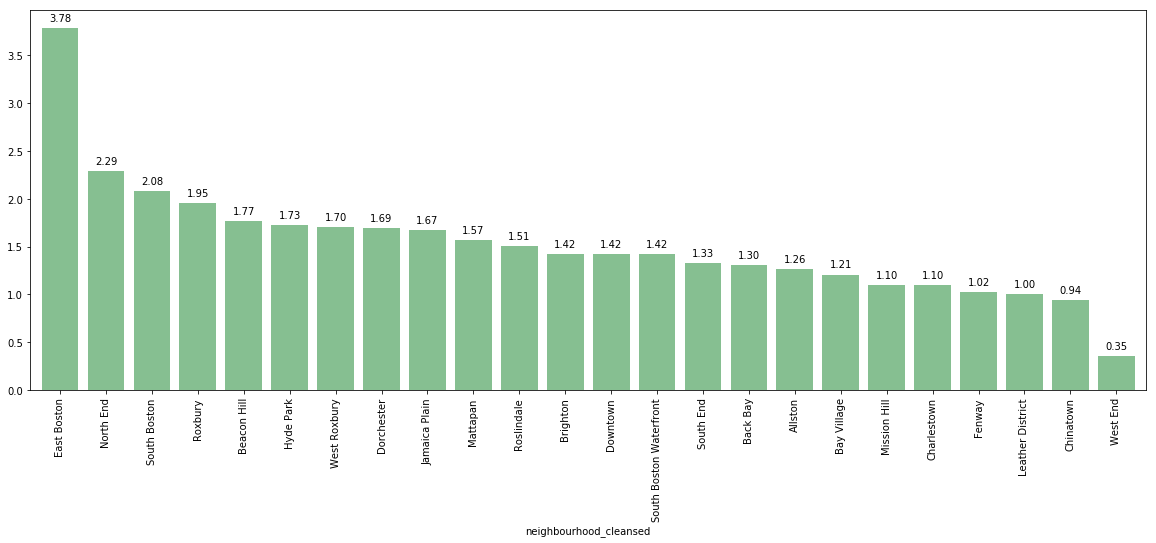

In [469]:
fig, ax = make_ax(20, 7)
neighbourhood_reviews_per_month= listings.groupby('neighbourhood_cleansed').reviews_per_month.mean().sort_values(ascending=False)
neighbourhood_reviews_per_month.plot(kind='bar', color='#86bf91', zorder=2, width=0.8, ax=ax)
add_value_labels(ax)

/usr/local/lib/python3.5/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


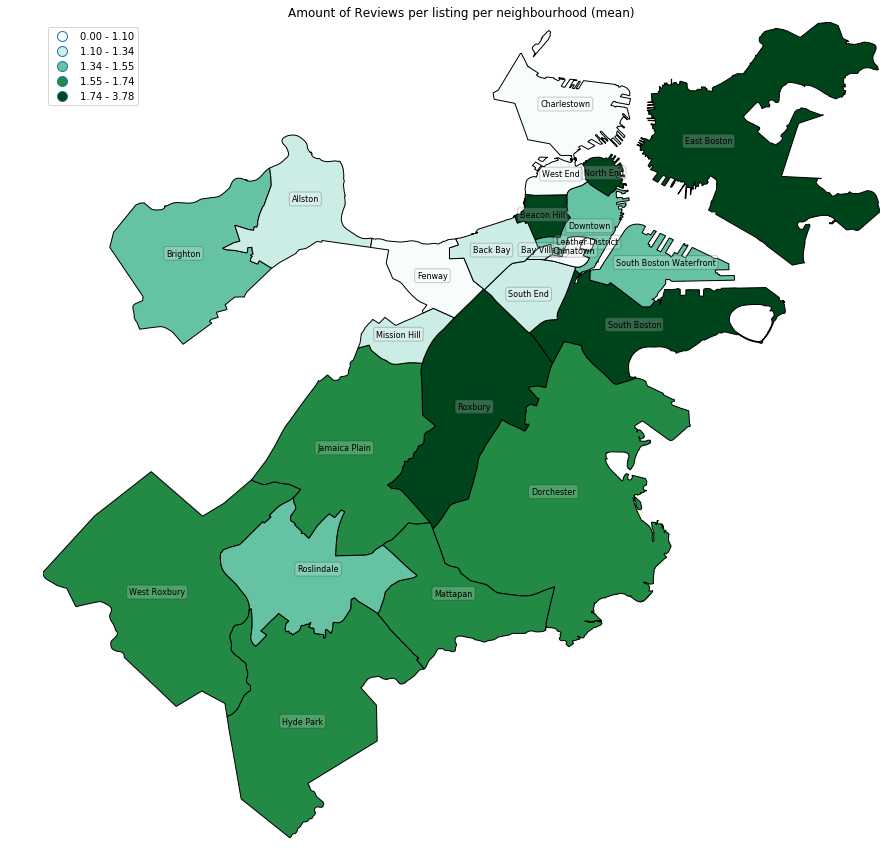

In [470]:
fig, ax = make_ax(15, 15)
neighbourhood_reviews_per_month_geo = add_geometry(neighbourhood_reviews_per_month)
geoplot.choropleth(neighbourhood_reviews_per_month_geo, hue='reviews_per_month', cmap = 'BuGn', legend=True, ax=ax);
ax.set_title('Amount of Reviews per listing per neighbourhood (mean)');

for idx, row in neighbourhood_reviews_per_month_geo.iterrows():
    ax.annotate(s=row['neighbourhood_cleansed'], 
                xy=row['coords'],
                bbox=dict(boxstyle="round", alpha=0.2, fc='White'), 
                horizontalalignment='center', fontsize=8)

- With the previous vizualizations it is possible to see the mean reviews per month for the different neighbourhoods.
- The Most Attractive Neighbourhoods are **East Boston (Close to Airport)** (3.8) , **North End** (2.3) and **South Boston** (2.1)
- The Least Attractive Neighbourhoods are **Fenway** (1), **Chinatown** (0.9) and **West End** (0.4)
- It is expected that cheaper neighbourhoods that are closer to the center have more listings with higher reviews per month, such as **Roxbury**, **South Boston** and **East Boston**
- We can also explain the fact that **East Boston** has many reviews per month. This might be because of its closeness to the Airport. People would come for a short trip and stay close to the Airport, resulting in more reviews per month.

### Best Rated Neighbourhoods

(8, 10)

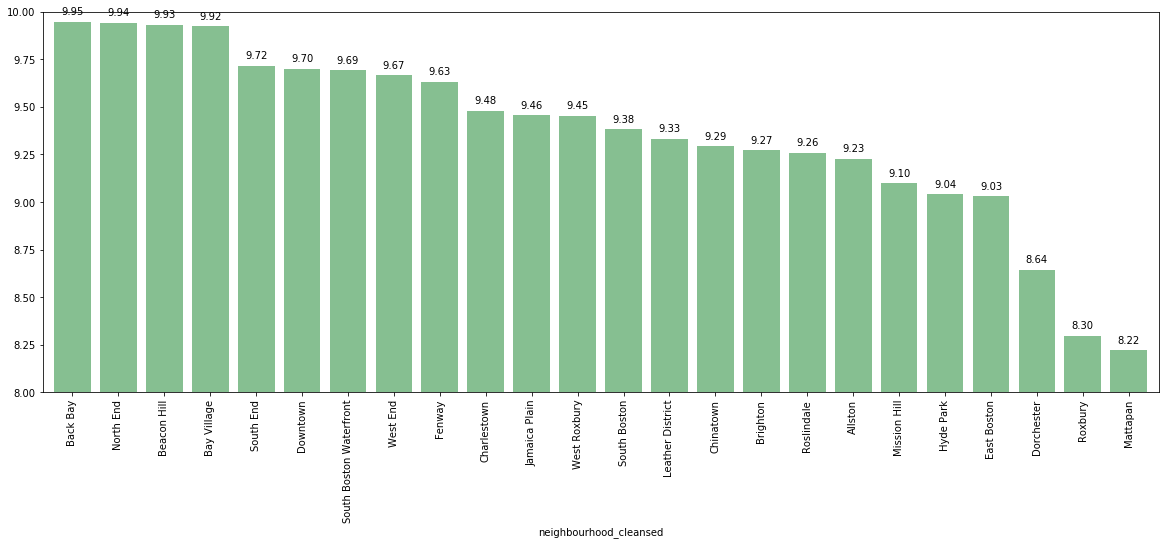

In [471]:
fig, ax = make_ax(20, 7)
neighbourhood_rating= listings[listings.review_scores_location!=-9999].groupby('neighbourhood_cleansed').review_scores_location.mean().sort_values(ascending=False)
neighbourhood_rating.plot(kind='bar', color='#86bf91', zorder=2,width=0.8, ax=ax)
add_value_labels(ax)
ax.set_ylim([8,10])


/usr/local/lib/python3.5/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


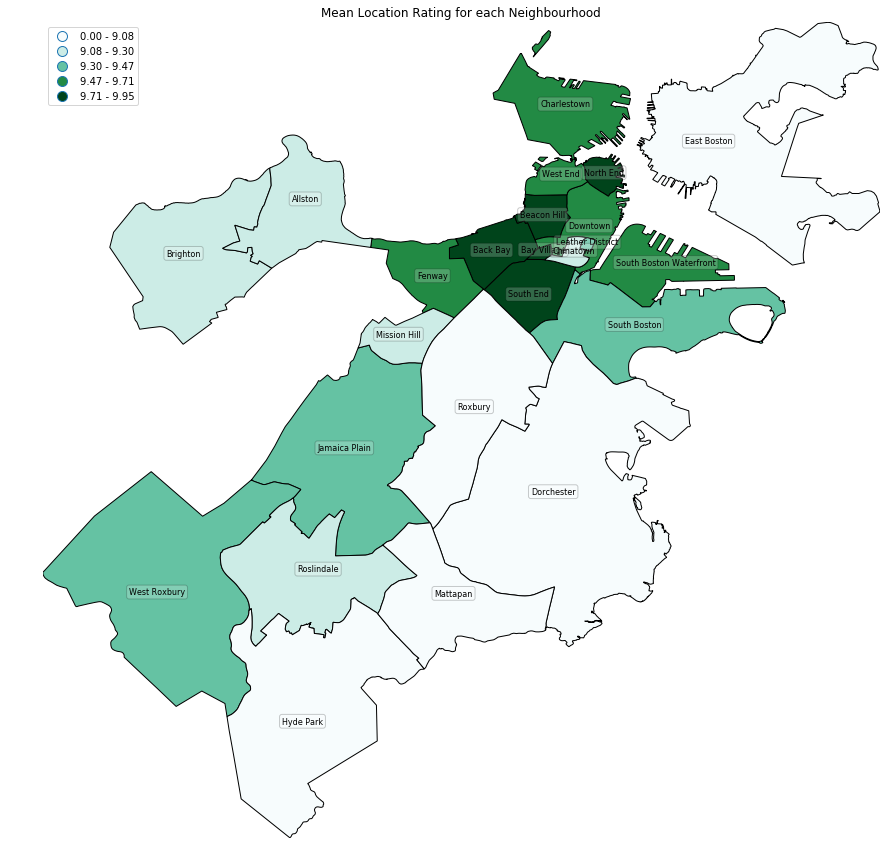

In [472]:
fig, ax = make_ax(15, 15)
neighbourhood_rating_geo = add_geometry(neighbourhood_rating)
geoplot.choropleth(neighbourhood_rating_geo, hue='review_scores_location', cmap = 'BuGn', legend=True, ax=ax);
ax.set_title('Mean Location Rating for each Neighbourhood');

for idx, row in neighbourhood_rating_geo.iterrows():
    ax.annotate(s=row['neighbourhood_cleansed'], 
                xy=row['coords'],
                bbox=dict(boxstyle="round", alpha=0.2, fc='White'), 
                horizontalalignment='center', fontsize=8)

- With the previous vizualizations it is possible to see the mean location rating for the different neighbourhoods.
- The Most Attractive Neighbourhoods are **Back Bay** (9.95) , **North End** (9.94), **Bay Village** (9.93) and **Bacon Hill** (9.9)
- The Least Attractive Neighbourhoods are **Dorchester** (8.64), **Roxbury** (8.3) and **Mattapan** (8.22)
- Again we see a trend that travellers prefer a location close to the center of the city (Except **Chinatown** and **Leather District**)
- We can also see that the previous high review per month **East Boston** is not rated as well as neighbourhoods in the center.

### Final Insights

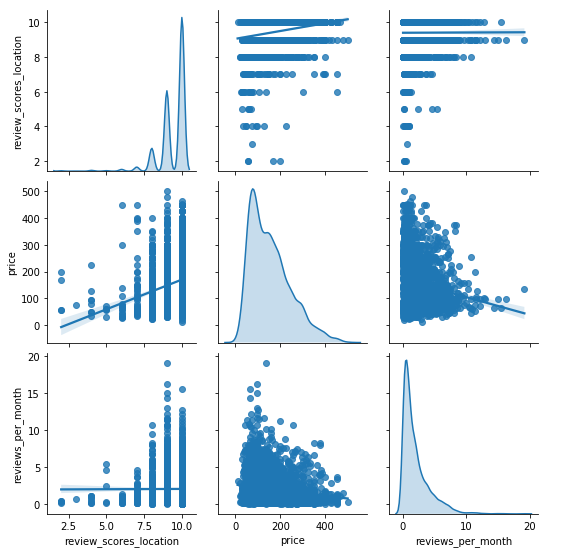

In [473]:
# We cannot use the unrated listings so we drop them for these statistics.

tmp = listings[listings.review_scores_location!=-9999]
sns.pairplot(data = tmp[['review_scores_location', 'price', 'reviews_per_month', 'neighbourhood_cleansed']], kind='reg', diag_kind='kde')

- From the Figure we can see that when the price tends to go up, the reviews per month tend to go down which means more expensive listings tend to be exclusive.
- Listings with higher location rating tend to have higher price
- There seems to be no correlation at a first sight between location rating and reviews per month. There is a bigger deviation though.

### Conclusion


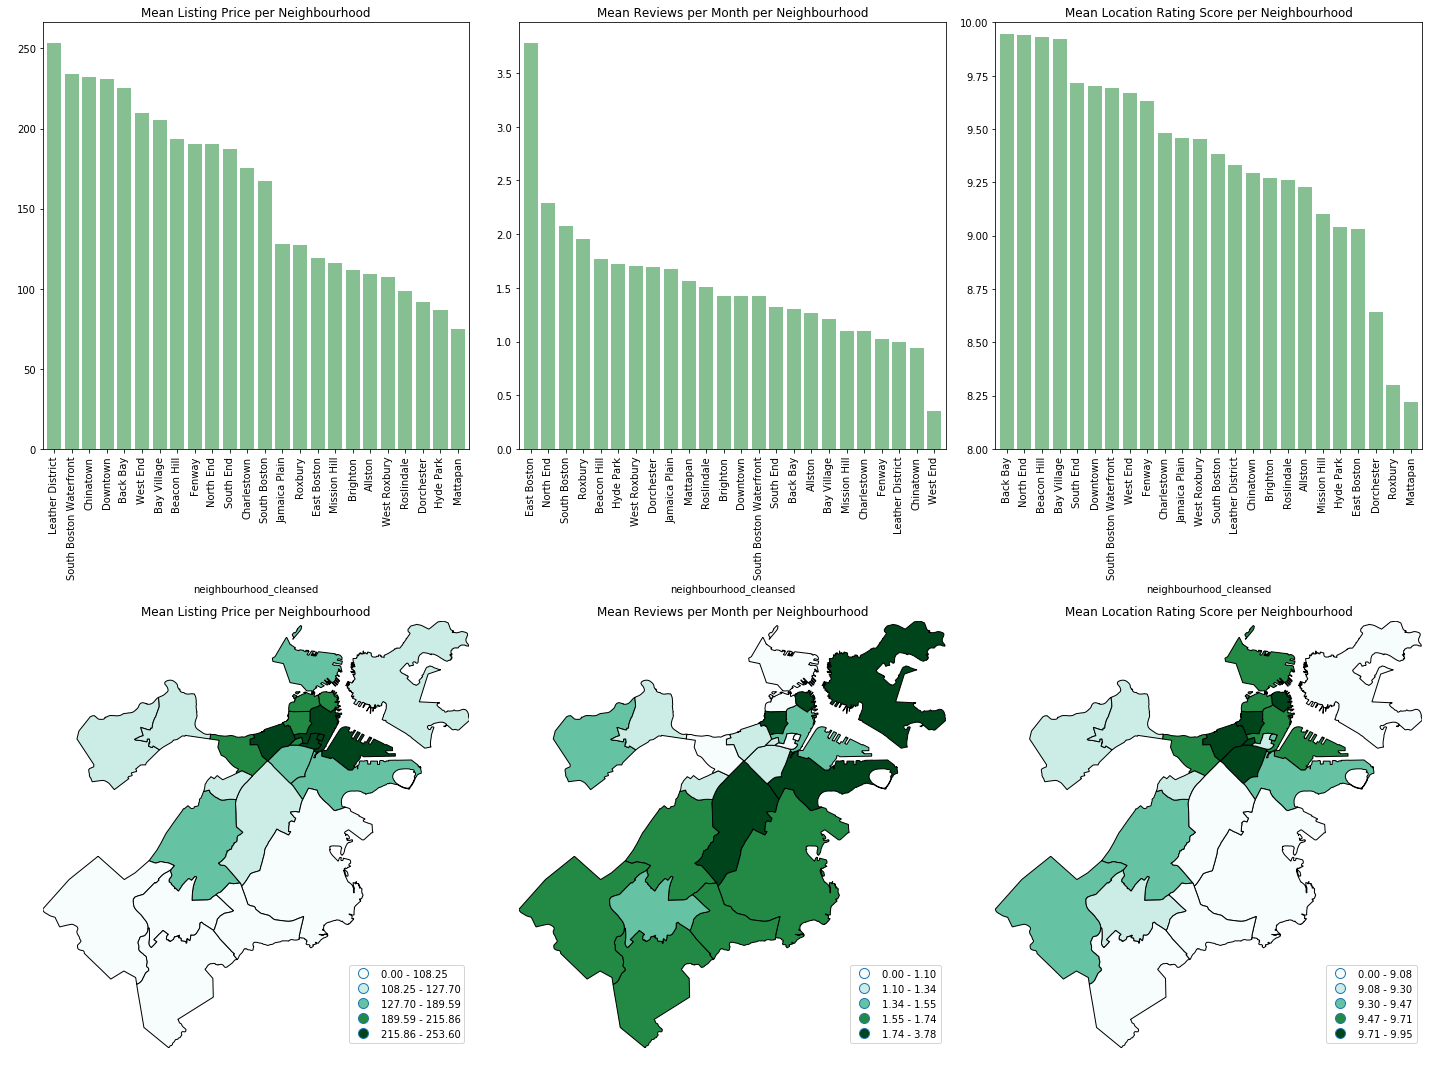

In [474]:
fig, ax = plt.subplots(2, 3, figsize=(20,15))

neighbourhoods_prices.plot(kind='bar', color='#86bf91', zorder=2, width=0.8, ax=ax[0, 0])
geoplot.choropleth(neighbourhood_prices_geo, hue='price', cmap = 'BuGn', legend=True, ax=ax[1,0]);

neighbourhood_reviews_per_month.plot(kind='bar', color='#86bf91', zorder=2, width=0.8, ax=ax[0,1])
geoplot.choropleth(neighbourhood_reviews_per_month_geo, hue='reviews_per_month', cmap = 'BuGn', legend=True, ax=ax[1,1]);

neighbourhood_rating.plot(kind='bar', color='#86bf91', zorder=2,width=0.8, ax=ax[0,2])
ax[0,2].set_ylim([8,10])
geoplot.choropleth(neighbourhood_rating_geo, hue='review_scores_location', cmap = 'BuGn', legend=True, ax=ax[1,2]);

ax[1,0].axis('off')
ax[1,1].axis('off')
ax[1,2].axis('off')
ax[0,0].set_title("Mean Listing Price per Neighbourhood")
ax[1,0].set_title("Mean Listing Price per Neighbourhood")
ax[0,1].set_title("Mean Reviews per Month per Neighbourhood")
ax[1,1].set_title("Mean Reviews per Month per Neighbourhood")
ax[0,2].set_title("Mean Location Rating Score per Neighbourhood")
ax[1,2].set_title("Mean Location Rating Score per Neighbourhood")


plt.tight_layout()

Depending on what kind of property want to own, the best neighbourhoods differ.

- In case of a more exclusive and expensive property, a listing in the city center like, **South Boston Waterfront**, **Chinatown** or **Leather District** seem to be the best choices since the price per night is much bigger than in other neighbourhoods but gets less reviews per month than others.
- In case of a continous rented listing, the right choices would be in the outskirts of the city center, where the location rating is still high (people can easily get to the center), and price is lower, which is more attractive for most travellers. Neighbourhoods that satisfy these criteria are for example: **East Boston** since it has an average of 4 reviews per month per listing and even though it is a bit cheaper, it compensates with more people coming in, **North End** and **South Boston** having great pricing and reviews per month.
- Might be interesting to outlie **East Boston** due to its proxmity to the airport and its high value in reviews per month. This might be due to the fact of people coming in for a quick few days vacation and staying in that district for just a few days.
- Regarding Location Rating, the best neigbourhoods are **Back Bay**, **North End**, **Beacon Hill** and **Bay Village**.

**To sum up:** It is profitable to host in a highly rated neighbourhood (location-wise) with high reviews per month and high price. 

A few contenders:

- Beacon Hill
- North End
- Downtown

## How does the price fluctuate throughout the year

What makes price change? Does it always stay the same? Probably not. It s nice to figure out when and why the priice fluctuates so you can stay at the top of your game and go with the flow of the prices. Let's get to it then.

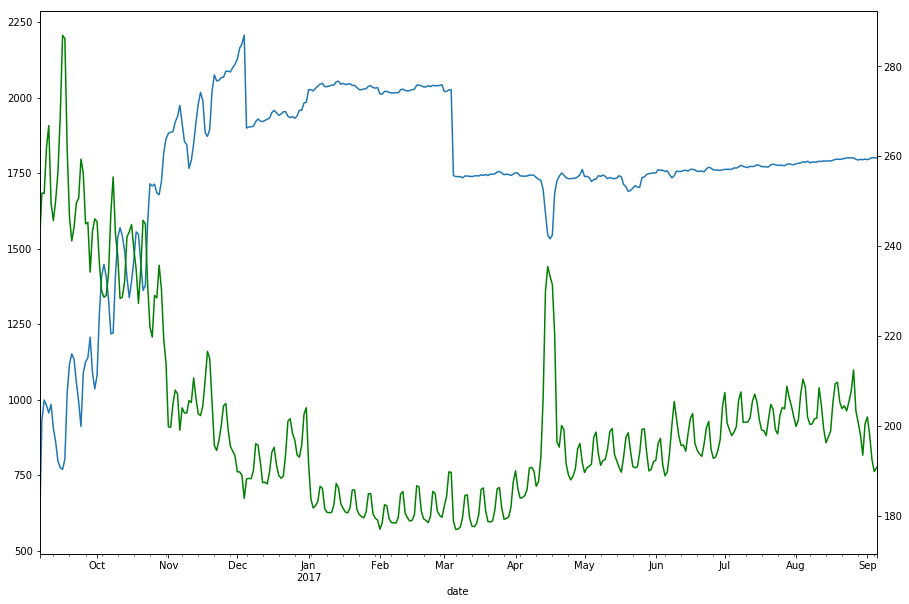

In [548]:
fig, ax = make_ax(15, 10)
calendar.groupby(pd.Grouper(key='date', freq='1d')).available.sum().plot(ax=ax);
ax1 = ax.twinx()
calendar.groupby(pd.Grouper(key='date', freq='1d')).price.mean().plot(ax=ax1, color='g');

- From the previous graph we can see at the end of the year of 2017 there is a big drop in prices of listings and then around mid may there is a sudden increase followed by a continous and slight increase.
- In the **End of 2017** the prices were very high due to the closeness between booking and stay. This means that the longer a person waits to book a listing, the more expensive it gets. Furthermore, there seems to be a relationship between the availability and the price. In the end of 2017 and mid may the availability was low and so the prices went up. 
- Around **Mid April** the prices sky-rocketed probably due to some massive event happening in the city. With a quick research we can see it was probably because of the Boston Marathon.
- Finally we can see a trend on pricing going up for the **summer months** until around September, starting to decrease once more.

## What is mostly correlated with being a superhost?

When we look for listings to stay we stumble upon a few hosts that have the title of **Superhost**. Why is that? What makes a Superhost super? 

To answer this I made a correlation matrix and checked the features that were the most correlated with being a superhost. 

Before actually going to the data.. What do you think makes a superhost? Probably someone who is reliable, who has been hosting for a while and has hosted several people in the past having great ratings from them? Is this the reason? Let's find out.

In [554]:
# Get dummy variables for categorical values, so they are also part of out matrix.
dummy_cols = ["host_response_time", "neighbourhood_cleansed", "property_type", "room_type", "bed_type", "cancellation_policy"]
listings = pd.get_dummies(listings, columns=dummy_cols)

In [555]:
# listings with no rating will mess with out matrix and we know that people without ratings cannot be superhosts. 
# we can remove the rows of the listings wth no ratings.
listings[listings.review_scores_location==-9999].review_scores_location = None

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [556]:
listings.sample(2)

,id,last_scraped,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,street,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,host_verifications_amex,host_verifications_email,host_verifications_facebook,host_verifications_google,host_verifications_jumio,host_verifications_kba,host_verifications_linkedin,host_verifications_manual_offline,host_verifications_manual_online,host_verifications_phone,host_verifications_reviews,host_verifications_sent_id,host_verifications_weibo,amenities_24-Hour Check-in,amenities_Air Conditioning,amenities_Breakfast,amenities_Buzzer/Wireless Intercom,amenities_Cable TV,amenities_Carbon Monoxide Detector,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Elevator in Building,amenities_Essentials,amenities_Family/Kid Friendly,amenities_Fire Extinguisher,amenities_First Aid Kit,amenities_Free Parking on Premises,amenities_Free Parking on Street,amenities_Gym,amenities_Hair Dryer,amenities_Hangers,amenities_Heating,amenities_Hot Tub,amenities_Indoor Fireplace,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Laptop Friendly Workspace,amenities_Lock on Bedroom Door,amenities_Other pet(s),amenities_Paid Parking Off Premises,amenities_Pets Allowed,amenities_Pets live on this property,amenities_Pool,amenities_Safety Card,amenities_Shampoo,amenities_Smoke Detector,amenities_Smoking Allowed,amenities_Suitable for Events,amenities_TV,amenities_Washer,amenities_Washer / Dryer,amenities_Wheelchair Accessible,amenities_Wireless Internet,host_for_days,Name,geometry,host_response_time_Never,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,property_type_Condominium,property_type_Dorm,property_type_Entire Floor,property_type_Guesthouse,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30
2641,9926796,2016-09-07,51026962,Ming,2015-12-10,1.00,0.92,0,1,1,0,"Grove St, West Roxbury, MA 02132, United States",42.26569,-71.159895,1,1.0,1.0,1.0,48.0,20.0,1,0.0,2,1125,30,60,90,365,7,66.0,8.0,7.0,9.0,8.0,9.0,7.0,0,0,0,0.91,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0

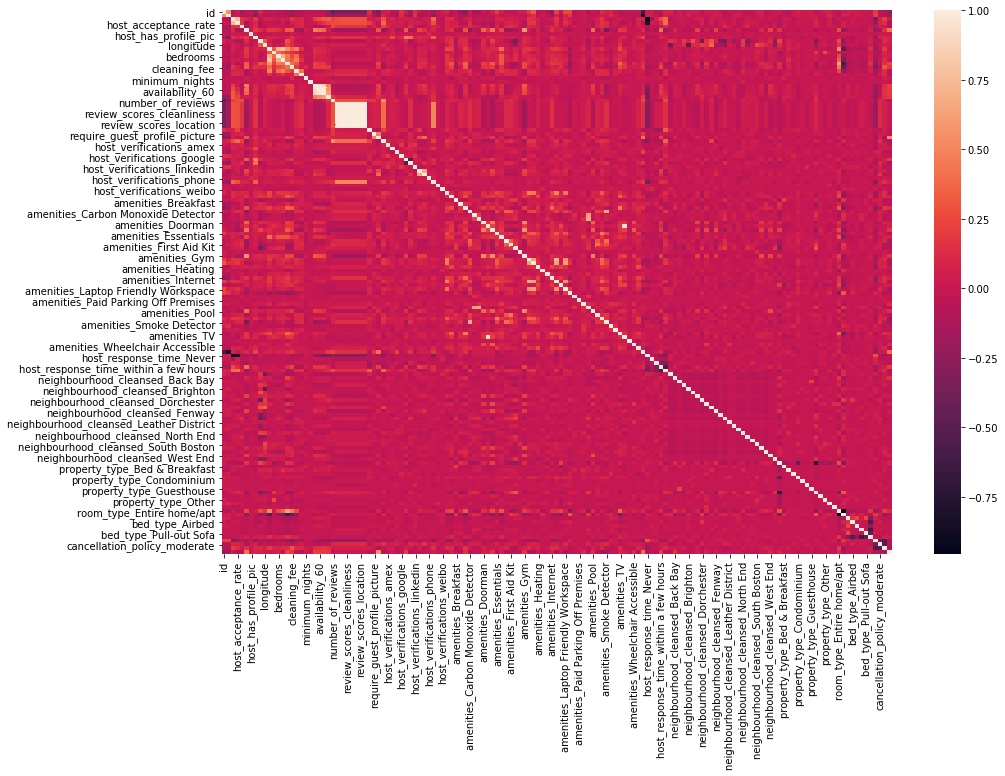

In [557]:
# make correlation heatmap
fig, ax = make_ax(15, 10)
sns.heatmap(listings.corr(), ax=ax)

Seems a little too much information for the eyes right? Let's tidy up a bit.
1. Choose host_is_superhost feature
2. Sort the correlation values
3. Pick the top 5

In [559]:
# Getting top 5 correlated features
top_5_corr = abs(listings.corr()["host_is_superhost"]).sort_values(ascending=False).head(6)

In [560]:
# Getting the columns from the top 5 correlated features
top_corr_cols = top_5_corr.index.values

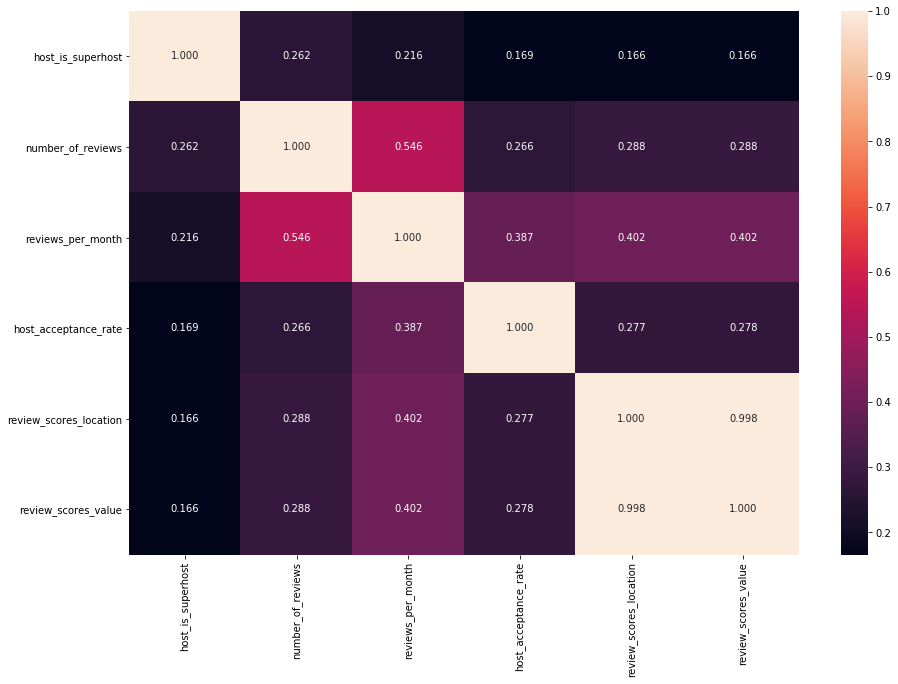

In [561]:
# Generate Map
fig, ax = make_ax(15, 10)
sns.heatmap(listings[top_corr_cols].corr(), annot=True,fmt=".3f",ax=ax);

Ah... This looks a little better.

**CONCLUSIONS**: The 5 Most Highly Correlated Features with being a Superhost are:
1. Number of Reviews
2. Reviews per Month
3. Host Acceptance Rate
4. Location Review Score
5. Value Review Score


- Like i said before, it looks like the amount of reviews leads the race for becoming a superhost, followed by the acceptance rate and reviews. With this in mind, in order to become a superhost, you should focus on getting a lot of people to stay in your property and worry about the quality of their stay.

## What influences the prices the most?

It would be nice to know what are the features that have a higher weight on the price so you could get them and boost it up a bit right? Maybe there are some amenities that more expensive listings all have in common, maybe its again the neighbourhoods.

### Getting only numerical values

In [562]:
# Check the data types of our features so we can get only the numerical ones for our machine learning model
listings.dtypes

id                                                         int64
last_scraped                                      datetime64[ns]
host_id                                                    int64
host_name                                                 object
host_since                                        datetime64[ns]
host_response_rate                                       float64
host_acceptance_rate                                     float64
host_is_superhost                                          int64
host_listings_count                                        int64
host_has_profile_pic                                       int64
host_identity_verified                                     int64
street                                                    object
latitude                                                 float64
longitude                                                float64
accommodates                                               int64
bathrooms                

In [564]:
# select only the integer and float features since our model only allows for numericals
features_for_model = listings.select_dtypes(include=['float', 'int', 'uint8'])\
    .drop(['id', 'host_id', 'latitude', 'longitude'], axis=1)

### Setting up data for modelling

In [565]:
# Create Features and Label, X and y

X = features_for_model.drop(['price'], axis=1)
y = features_for_model['price']

In [602]:
# Create training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=34)

### Create Model

In [605]:
#Use of Bayesian Ridge so we dont have to put a regularization term and it deals with overfitting on ts own

lm_model = BayesianRidge() 

### Train Model

In [606]:
# Fit the model to our training data
lm_model.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

### Evaluate Model

In [607]:
# Test the fitted model to our test data

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

In [608]:
#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print("The R2 Score of the training set is {} and for the test set is {}".format(train_score, test_score))

The R2 Score of the training set is 0.7047801422347129 and for the test set is 0.6853208193452294


This means that out model can explain the variance of 68.5% of the test data.

### Feature Importance

- Having our trained and evaluated model we can then take a look at the weight coefficents which will tell us which features will affect more the end result, in this case, the price.

In [619]:
# Get the coefficients into a dataframe format and get top ones
coef_df = coef_weights(lm_model.coef_, X_train).set_index('feature')
coef_df.abs().sort_values(by='coefs', ascending=False).head(20)

,coefs
feature,
room_type_Entire home/apt,42.877291
neighbourhood_cleansed_Back Bay,41.514104
neighbourhood_cleansed_Downtown,38.208097
neighbourhood_cleansed_Roslindale,36.531374
neighbourhood_cleansed_Dorchester,34.443675
cancellation_policy_super_strict_30,31.710674
neighbourhood_cleansed_Beacon Hill,31.652949
require_guest_phone_verification,30.676308
room_type_Shared room,30.370963


#### Feature Importance Visualisation

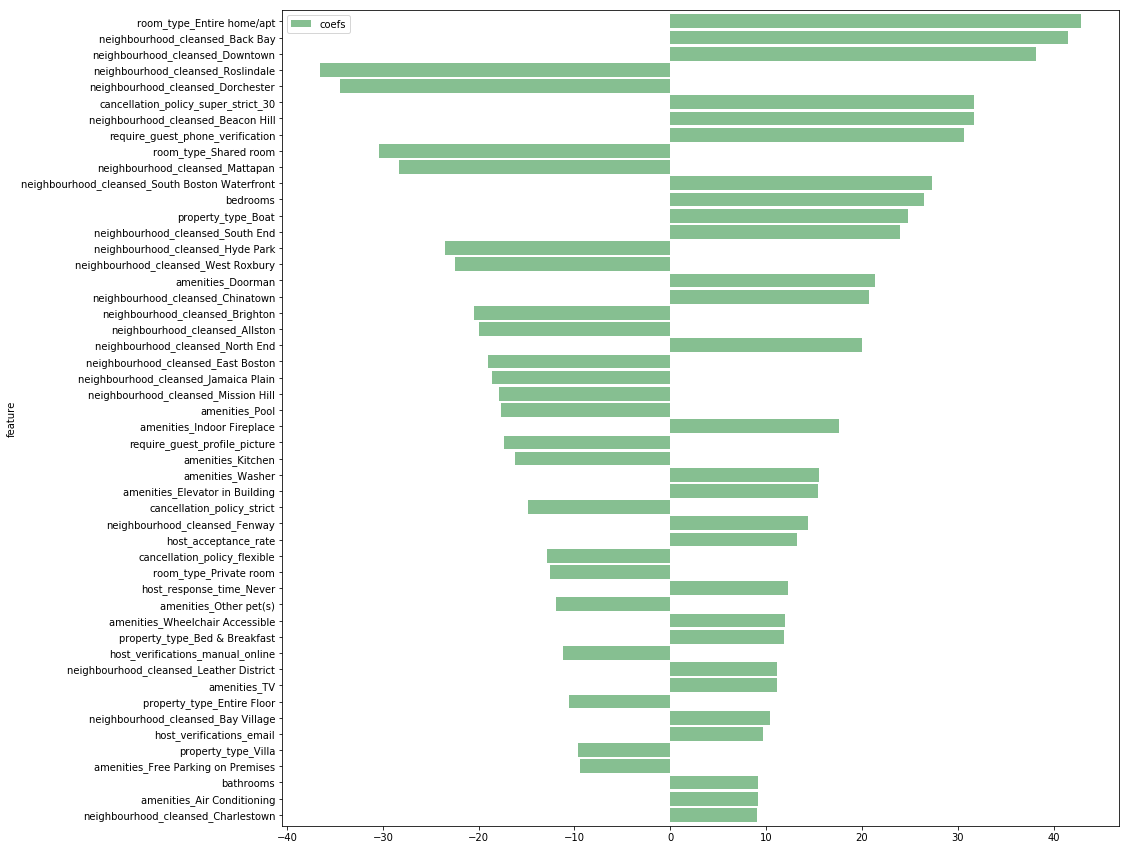

In [622]:
# Create bar chart of the above dataframe

fig, ax = make_ax(15, 15)
coef_df.reindex(coef_df.abs().sort_values(by='coefs', ascending=False).index).head(50)\
    .plot(kind='barh', ax=ax, color='#86bf91', zorder=2, width=0.85);
ax.invert_yaxis()

As we can see, the features that most influence the price are:

1. **Entire Home / Apartment** (Room Type)
2. **Backbay** (Neighbourhood)
3. **Downtown** (Neighbourhood)
4. **Rosindale** (Neighbourhood)
5. **Dorchester** (Neighbourhood)

Wow. The neighbourhood really holds an imense weight on the price of a listing. 

Let's then check the feature importance by group.

#### Feature Importance by Group

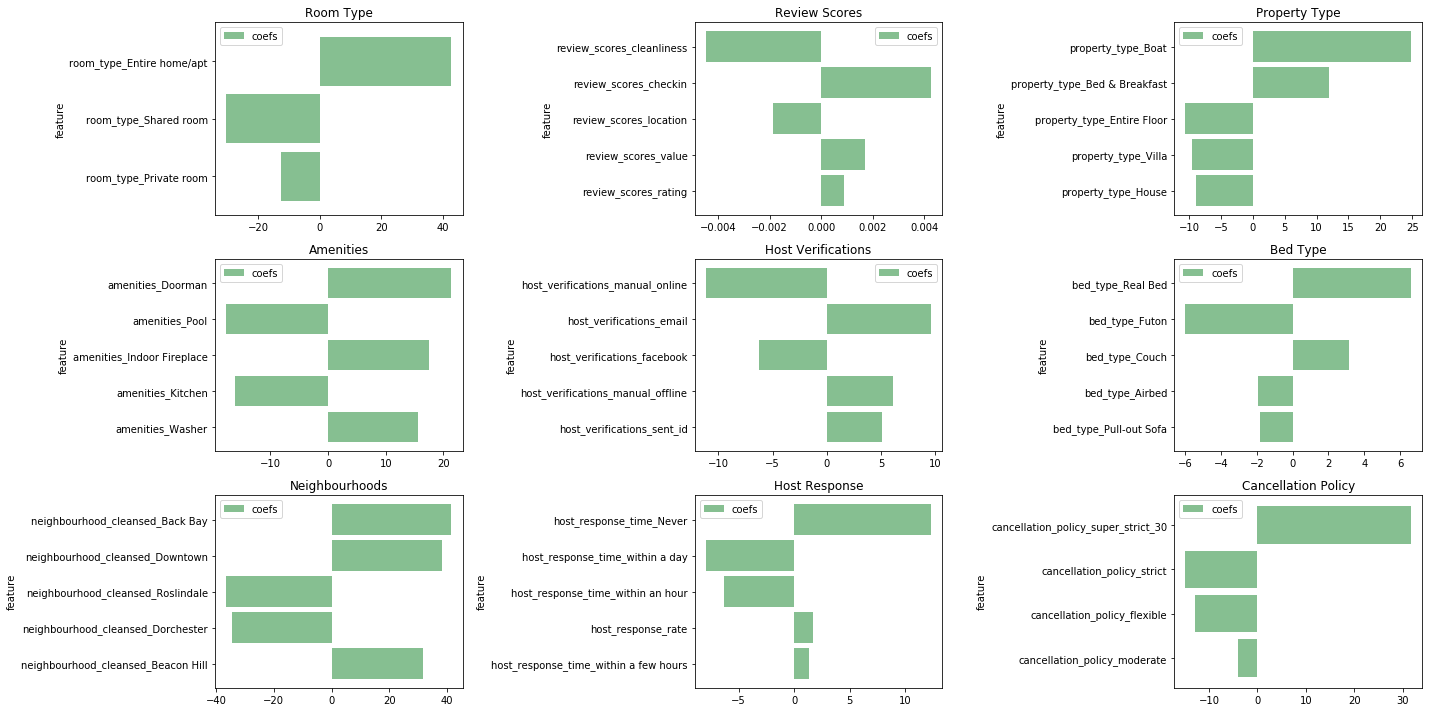

In [624]:
# creating several different visualizations for the different feature groups

fig, ax = plt.subplots(3, 3, figsize=(20,10))

tmp = coef_df.filter(like='room_type', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh',  ax=ax[0,0], color='#86bf91', zorder=2, width=0.85);
ax[0,0].set_title("Room Type")

tmp = coef_df.filter(like='amenities', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5).\
    plot(kind='barh',  ax=ax[1,0], color='#86bf91', zorder=2, width=0.85);
ax[1,0].set_title("Amenities")

tmp = coef_df.filter(like='neighbourhood', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh', ax=ax[2,0], color='#86bf91', zorder=2, width=0.85);
ax[2,0].set_title("Neighbourhoods")

tmp = coef_df.filter(like='review_scores', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh',  ax=ax[0,1], color='#86bf91', zorder=2, width=0.85);
ax[0,1].set_title("Review Scores")

tmp = coef_df.filter(like='host_verifications', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh',  ax=ax[1,1], color='#86bf91', zorder=2, width=0.85);
ax[1,1].set_title("Host Verifications")

tmp = coef_df.filter(like='host_response', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh',  ax=ax[2,1], color='#86bf91', zorder=2, width=0.85);
ax[2,1].set_title("Host Response")

tmp = coef_df.filter(like='property_type', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh',  ax=ax[0,2], color='#86bf91', zorder=2, width=0.85);
ax[0,2].set_title("Property Type")

tmp = coef_df.filter(like='bed_type', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh',  ax=ax[1,2], color='#86bf91', zorder=2, width=0.85);
ax[1,2].set_title("Bed Type")

tmp = coef_df.filter(like='policy', axis=0)
tmp.reindex(tmp.abs().sort_values(by='coefs', ascending=False).index).head(5)\
    .plot(kind='barh',  ax=ax[2,2], color='#86bf91', zorder=2, width=0.85);
ax[2,2].set_title("Cancellation Policy")

i=0
j=0

while i <= 2:
    j=0
    while j <=2:
        ax[i,j].invert_yaxis()
        j += 1
    i += 1

plt.tight_layout()


Here we can see the top features within each group.

- **Room type**: Entire Home / Appartment
- **Review Scores**: Cleaniness & CheckIn
- **Property Type**: Boat
- **Amenities**: Doorman, Pool and Fireplace
- **Host Verifications**: Manual Online & Email
- **Bed Type**: Real Bed & Futon
- **Neighbourhood**: Back Bay, Downtown, Roslindale, Dorchester, Beacon Hill
- **Host Response**: Never and Within a day /hour
- **Cancellation Policy**: Super Strict 30

These are the features a new host needs to care more about. But please understand that having/not having a feature does not exactly guarantee a higher or lower price. For example, dont just put a super strict cancellation policy just because it says here that it weights a lot on the model. Again our model only explains about 70% of the variance. But it makes sense that if you have a doorman than that deserves a bump in the price.